Сначала SQL-запросом создадим таблицы, с которыми будем работать в python. Запросы выполняются непосредственно в базе данных.

In [ ]:
SELECT [ISIN], [CPN] INTO [risks].[dbo].[coupon_data]
FROM [risks].[dbo].[base_prices]
WHERE [CPN] != ' ';
UPDATE [risks].[dbo].[coupon_data]
SET [CPN] = REPLACE([CPN], ',', '.');
ALTER TABLE [risks].[dbo].[coupon_data] ALTER COLUMN [CPN] float NOT NULL;
GO
#средний размер купоны
SELECT [ISIN], AVG([CPN]) as coupon
INTO [risks].[dbo].[coupon_data2]
FROM [risks].[dbo].[coupon_data]
GROUP BY [ISIN]
GO
#таблица для работы
SELECT [ISIN, RegCode, NRDCode], [IssuerName], [SumMarketVal], [EndMtyDate], [BegDistDate], [SecurityType], [CouponType], [HaveOffer], [CouponPerYear], [Basis], [FaceFTName], [AmortisedMty], [FaceValue], [coupon]
INTO [risks].[dbo].[bond_information]
FROM [risks].[dbo].[bond_discription] LEFT JOIN [risks].[dbo].[coupon_data2]
ON [risks].[dbo].[bond_discription].[ISIN, RegCode, NRDCode] = [risks].[dbo].[coupon_data2].[ISIN]
WHERE [IssuerName] !=' '
GO

Для выполнения следующих пунктов понадобится MS SQL Sevrer, ODBC Driver 17 for SQL Serve, Python 3.7 (Jupyter notebook).
Необходимо настроить подключение Python к базе по ODBC. Для этого необходимо установить расширение pyodbc, прописав в командной строке:
pip install pyodbc
Если ранее не было создано имя для подключения к серверу, необходимо создать его через вкладку Безопасность-Имена для входа и использовать эти данные для подключения к базе данных. 

In [3]:
import pandas as pd
import pyodbc 
server = 'HOME\SQLEXPRESS' 
database = 'risks' 
username = 'IT' 
password = '1111' 
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)


Выполним запрос на вывод списка эмитентов

In [4]:
df = pd.read_sql("SELECT [IssuerName] FROM [risks].[dbo].[bond_information] GROUP BY [IssuerName]", conn)
df

,IssuerName
0,4finance S.A
1,Ak Bars Luxembourg
2,Alfa Bond Issuance
3,Alfa Holding Issuance
4,"Alrosa Finance, Luxemb."
5,BKM Finance
6,Borets Finance
7,BrokerCreditService SP
8,Brunswick Rail Finance
9,Caterpillar InternFinance


Постороим bar plot с срочной структурой погашения облигаций нашего эмитента. По оси x будет время в годах, а по оси ординат - объем.

In [12]:
OurIssuer = input('Введите имя эмитента ') 

Введите имя эмитента РЖД


In [13]:
OurDate = input('Введите дату в формате YYYY-MM-DD: ')

Введите дату в формате YYYY-MM-DD: 2011-01-01


In [14]:
OurDate=pd.to_datetime(OurDate)

In [15]:
SQLQuery2 = (""" 
SELECT * FROM [risks].[dbo].[bond_information] 
""")
bonds = pd.read_sql(SQLQuery2, conn)
OurBonds = bonds[(bonds['EndMtyDate'] > OurDate) & (bonds['BegDistDate'] < OurDate) & (bonds['IssuerName'] == OurIssuer) & (bonds['FaceFTName'] == 'RUB')]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

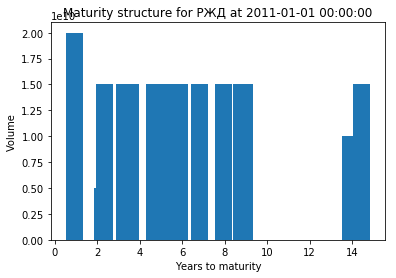

In [16]:
OurBonds.insert(5,'OurDate',OurDate)
OurBonds['time_to_maturity'] = OurBonds['EndMtyDate'] - OurBonds['OurDate']
import numpy as np
OurBonds['time_to_maturity']= (OurBonds['time_to_maturity'] / np.timedelta64(1, 'D')).astype(int)
OurBonds['time_to_maturity'] = OurBonds['time_to_maturity']/365
import matplotlib.pyplot as plt
Volume = OurBonds['SumMarketVal']
Days_to_maturity=OurBonds['time_to_maturity']
plt.bar(Days_to_maturity,Volume, width = 0.8, align = 'edge')
plt.xlabel('Years to maturity')
plt.ylabel('Volume')
plt.title('Maturity structure for '+str(OurIssuer) +' at ' + str(OurDate))
plt.show()

Постороение круговой диаграммы. Необходимо сначала разбить данные на три группы по срочности. Определим те облигации, срок погашения которых меньше 5 и более 10 лет.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


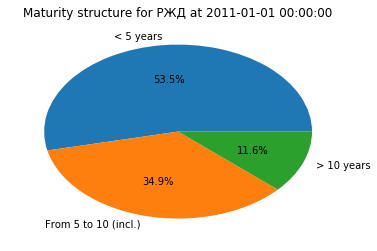

In [17]:
OurBonds['<5'] = OurBonds['time_to_maturity'] < 5
OurBonds['>10'] = OurBonds['time_to_maturity'] > 10
a = OurBonds.loc[OurBonds['<5']== True, 'SumMarketVal'].sum()
b = OurBonds.loc[(OurBonds['<5']== False) & ((OurBonds['>10']== False)), 'SumMarketVal'].sum()
c = OurBonds.loc[OurBonds['>10']== True, 'SumMarketVal'].sum()
Volumes = [a,b,c]
Groups = ['< 5 years', 'From 5 to 10 (incl.)', '> 10 years']
plt.pie( Volumes, labels= Groups, shadow=False, autopct='%1.1f%%',)
plt.title('Maturity structure for '+str(OurIssuer) +' at ' + str(OurDate))
plt.show()


Выведем облигации эмитента с заданными параметрами

In [18]:
OurBonds

,"ISIN, RegCode, NRDCode",IssuerName,SumMarketVal,EndMtyDate,BegDistDate,OurDate,SecurityType,CouponType,HaveOffer,CouponPerYear,Basis,FaceFTName,AmortisedMty,FaceValue,coupon,time_to_maturity,<5,>10
249,RU000A0GJNG2,РЖД,5.000000e+09,2012-11-07,2005-11-18,2011-01-01,Корп,Постоянный,0.0,2.0,act/365,RUB,0.0,1000.0,37.650000,1.852055,True,False
939,RU000A0JPW61,РЖД,2.000000e+10,2011-07-06,2008-07-11,2011-01-01,Корп,Постоянный,0.0,2.0,act/365,RUB,0.0,1000.0,42.380000,0.509589,True,False
1002,RU000A0JQ136,РЖД,1.500000e+10,2013-11-13,2008-11-21,2011-01-01,Корп,Переменный,1.0,2.0,act/365,RUB,0.0,1000.0,27.023033,2.868493,True,False
1005,RU000A0JQ177,РЖД,1.500000e+10,2015-11-18,2008-11-28,2011-01-01,Корп,Переменный,1.0,2.0,act/365,RUB,0.0,1000.0,38.890045,4.882192,True,False
1029,RU000A0JQ4F1,РЖД,1.500000e+10,2014-03-06,2009-03-14,2011-01-01,Корп,Постоянный,0.0,2.0,act/365,RUB,0.0,1000.0,74.790000,3.178082,True,False
1030,RU000A0JQ4G9,РЖД,1.500000e+10,2014-03-06,2009-03-14,2011-01-01,Корп,Переменный,1.0,2.0,act/365,RUB,0.0,1000.0,12.332058,3.178082,True,False
1035,RU000A0JQ4U0,РЖД,1.500000e+10,2015-04-07,2009-04-16,2011-01-01,Корп,Постоянный,1.0,2.0,act/365,RUB,0.0,1000.0,42.320182,4.265753,True,False
1054,RU000A0JQ5Q5,РЖД,1.500000e+10,2019-05-16,2009-05-30,2011-01-01,Корп,Переменный,1.0,2.0,act/365,RUB,0.0,1000.0,43.214515,8.375342,False,False
1062,RU000A0JQ656,РЖД,1.500000e+10,2017-06-05,2009-06-17,2011-01-01,Корп,Переменный,1.0,2.0,act/365,RUB,0.0,1000.0,42.903457,6.430137,False,False
1077,RU000A0JQ6S9,РЖД,1.500000e+10,2016-06-20,2009-07-01,2011-01-01,Корп,Постоянный,1.0,2.0,act/365,RUB,0.0,1000.0,45.397030,5.471233,False,False


Запросим интересующую облигацию

In [24]:
OurISIN = input('введите ISIN одной из облигаций эмитента ') 

введите ISIN одной из облигаций эмитента RU000A0JPW61


In [26]:
OurBond = OurBonds[OurBonds['ISIN, RegCode, NRDCode'] == OurISIN]
OurBond

,"ISIN, RegCode, NRDCode",IssuerName,SumMarketVal,EndMtyDate,BegDistDate,OurDate,SecurityType,CouponType,HaveOffer,CouponPerYear,Basis,FaceFTName,AmortisedMty,FaceValue,coupon,time_to_maturity,<5,>10
939,RU000A0JPW61,РЖД,2.000000e+10,2011-07-06,2008-07-11,2011-01-01,Корп,Постоянный,0.0,2.0,act/365,RUB,0.0,1000.0,42.38,0.509589,True,False


Тип данной облигации, вид купона и наличии оферт.

In [27]:
OurBond [['ISIN, RegCode, NRDCode', 'SecurityType' ,'CouponType', 'HaveOffer']]

,"ISIN, RegCode, NRDCode",SecurityType,CouponType,HaveOffer
939,RU000A0JPW61,Корп,Постоянный,0.0


Структура платежей по облигации, оставшихся от выбранной даты до даты погашения, если облигация имеет постоянный купон, не имеет аферты и не является амортизируемой.

In [28]:
if OurBond['CouponType'].all() == 'Постоянный' and OurBond['HaveOffer'].all() == 0 and OurBond['AmortisedMty'].all() == 0:
    structure = pd.DataFrame(data={'date': [], 'payment': []})
    from datetime import datetime, timedelta
    j = OurBond.loc[:,'EndMtyDate'].astype(object).all()
    i=0
    structure.at[i, 'date'] = j
    structure.at[i, 'payment'] = OurBond['coupon'] + OurBond['FaceValue']
    while j >= OurBond['OurDate'].astype(object).all():
        j -= timedelta(days=365/OurBond.loc[:,'CouponPerYear'].sum())
        i += 1
        structure.at[i, 'date'] = j
        structure.at[i, 'payment'] = OurBond['coupon']
    print(structure)
else:
    print('Облигация не подходит: тип ее купона не является постоянным, в облигацию встроена аферта или же она является амортизируемой')

                 date  payment
0 2011-07-06 00:00:00  1042.38
1 2011-01-04 12:00:00    42.38
2 2010-07-06 00:00:00    42.38


Выведем структуру платежей, если это возможно (для большинства облигаций не отображается т.к. не хватает данных)

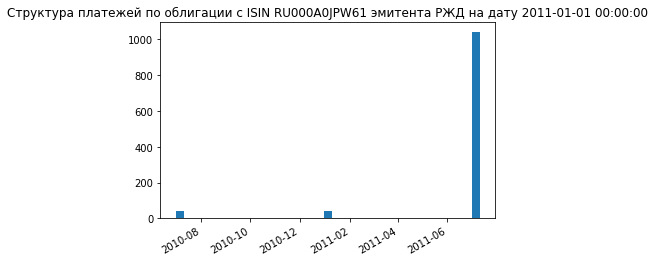

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(structure['date'].values,structure['payment'].values, width= 10)
plt.xlabel='Дата платежа'
plt.ylabel='Размер платежа'
plt.title('Структура платежей по облигации с ISIN '+str(OurISIN)+' эмитента '+str(OurIssuer) +' на дату ' + str(OurDate))
fig.autofmt_xdate()
plt.show()